In [8]:
import torch
from torch import nn

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

import tqdm

%matplotlib inline

# Hyperparameter

In [19]:
U_NUMBER = 5000
BATCH_SIZE = 1
LR = 0.1

b = 0.05
g = 9.81
l = 1
m = 1


# Create data

In [20]:
# inputs
u = torch.rand((U_NUMBER, 2)) * 6 - 3
t = torch.zeros((U_NUMBER, 1))

u_r = torch.rand((U_NUMBER, 2)) * 6 - 3
t_r = torch.rand((U_NUMBER, 1))

# output labels
s = u

print(u.shape, t.shape, u_r.shape, t_r.shape, s.shape)

torch.Size([5000, 2]) torch.Size([5000, 1]) torch.Size([5000, 2]) torch.Size([5000, 1]) torch.Size([5000, 2])


In [21]:
class PI_dataset(torch.utils.data.Dataset):
  def __init__(self, u, t, s, u_r, t_r):
    self.u = u
    self.t = t
    self.s = s 
    self.u_r = u_r
    self.t_r = t_r

  def __len__(self):
    return self.u.shape[0]
  
  def __getitem__(self, idx):
    return self.u[idx], self.t[idx], self.s[idx], self.u_r[idx], self.t_r[idx]
    
dataset = PI_dataset(u, t, s, u_r, t_r)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True)


# Model, loss

In [22]:
class PI_deepONet(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    
    self.branch_net = nn.Sequential()
    self.trunk_net = nn.Sequential()

    architecture = [100, 100, 100, 100, 100, 100, 200]
    branch_input_dim = 2
    trunk_input_dim = 1
    for i, dim in enumerate(architecture):
      self.branch_net.add_module(f"layer {i}", nn.Linear(branch_input_dim, dim))
      self.branch_net.add_module(f"tanh {i}", nn.Tanh())

      self.trunk_net.add_module(f"layer {i}", nn.Linear(trunk_input_dim, dim))
      self.trunk_net.add_module(f"tanh {i}", nn.Tanh())
      
      branch_input_dim = dim
      trunk_input_dim = dim

  def forward(self, u, t):
    dot_out = self.branch_net(u) * self.trunk_net(t)
    s1 = dot_out[:, :100].sum(dim=-1)
    s2 = dot_out[:, 100:].sum(dim=-1)
    
    return s1, s2


In [23]:
def loss(model, u, t, s, u_r, t_r):
  # residual loss
  t_r =  copy.copy(t_r)
  t_r.requires_grad = True
  s1, _ = model(u_r, t_r)
  ds1_dt = torch.autograd.grad(s1, t_r)[0]

  _, s2 = model(u_r, t_r)
  ds2_dt = torch.autograd.grad(s2, t_r)[0]

  residual_loss = ((ds1_dt - s2)**2).mean() + ((ds2_dt + b/m * s2 - g/l * torch.sin(s1))**2).mean()

  # initial condition loss
  s1, s2 = model(u, t)
  s_hat = torch.hstack([s1, s2])
  ic_loss = ((s - s_hat)**2).mean()

  return residual_loss + ic_loss, residual_loss, ic_loss


In [24]:
model = PI_deepONet()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [27]:
with tqdm.tqdm(dataloader, unit="batch") as tepoch: 
  for i, (u, t, s, u_r, t_r) in enumerate(tepoch):
    optimizer.zero_grad()
    l, res_loss, ic_loss = loss(model, u, t, s, u_r, t_r)

    ic_loss.backward()
    optimizer.step()

    if i % 50 == 0:
      tepoch.set_description("iteration")
      tepoch.set_postfix(loss=l.item(), res_loss=res_loss.item(), ic_loss=ic_loss.item())


iteration: 100%|██████████| 5000/5000 [00:31<00:00, 158.26batch/s, ic_loss=6.57, loss=6.57, res_loss=3.08e-11]  


## start trial

In [17]:
for u, t, s, u_r, t_r in dataloader:
  break

# inference

In [6]:
from jax.experimental.ode import odeint
import jax.numpy as np
import matplotlib.pyplot as plt



In [4]:
b = 0.05
g = 9.81
l = 1
m = 1

def system(s, t):
  s1 = s[0]
  s2 = s[1]
  ds1_dt = s2
  ds2_dt =  - (b/m) * s2 - g * np.sin(s1)
  ds_dt = [ds1_dt, ds2_dt]
  return ds_dt

# Create the test data
T = 100 # Final time
dt = 1.0 
N = int(T / dt)

u0 = np.array([1.0, 1.0]) # initial state
y =  np.linspace(0, int(N * dt), int(100 * N)) 
s_exact = odeint(system, u0, y)

In [87]:
# Long time model prediction
P_test = 100  
u0_star = np.tile(u0, (P_test, 1))
y_star = np.linspace(0, dt, P_test).reshape(-1, 1)

s1_pred_0, s2_pred_0 = model(torch.tensor(u0_star, dtype=torch.float32), torch.tensor(y_star, dtype=torch.float32))
s1_pred = s1_pred_0.detach().numpy()
s2_pred = s2_pred_0.detach().numpy()

for k in range(1, N):
  u0 = np.hstack([s1_pred[-1], s2_pred[-1]])
  u_star = np.tile(u0, (P_test, 1))

  s1_pred_k, s2_pred_k = model(torch.tensor(u_star, dtype=torch.float32), torch.tensor(y_star, dtype=torch.float32))

  s1_pred = np.hstack([s1_pred, s1_pred_k.detach().numpy()])
  s2_pred = np.hstack([s2_pred, s2_pred_k.detach().numpy()])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


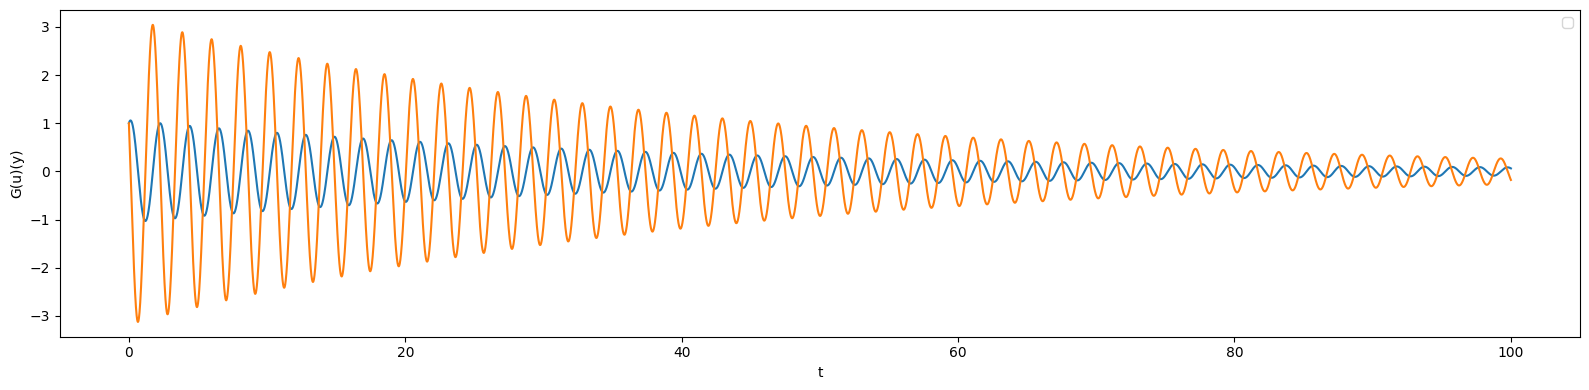

In [7]:
# Plot
fig = plt.figure(figsize=(16,4))
plt.plot(y, s_exact[:,0], color='C0')
plt.plot(y, s_exact[:,1], color='C1')
# plt.plot(y, s1_pred, '--', label='Predicted s1', lw=2, color='C3')
# plt.plot(y, s2_pred, '--', label='Predicted s2', lw=2, color='C4')
plt.xlabel('y')
plt.ylabel('G(u)(y)')
plt.xlabel('t')
plt.tight_layout()
plt.legend()
plt.show()


In [11]:
import torch
from functorch import make_functional, vmap, grad

model = torch.nn.Linear(3, 3)
data = torch.randn(64, 3, requires_grad=True)
out = model(data)
targets = torch.randn(64, 3)

params = dict(model.named_parameters())

def compute_loss(params, data, targets):
    preds = torch.func.functional_call(model, params, data)
    return torch.mean((preds - targets) ** 2)

torch.vmap(lambda x, y: torch.autograd.grad(y, x), (0, 0))(data, out)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn